In [1]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pandas pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet

In [3]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [4]:
# Project name used for jovian.commit
project_name = '03-cifar10-cnn'

# Exploring the CIFAR10 dataset

In [5]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

Extracting data/cifar-10-python.tar.gz to data/


In [6]:
dataset_size = len(dataset)
dataset_size

50000

In [6]:
img, label = dataset[0]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

# Preparing the data for training

In [7]:
torch.manual_seed(43)
val_size = 5000
train_size = len(dataset) - val_size

In [8]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

# Base model class & training on GPU

In [9]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [10]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [23]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr=lr, weight_decay=1e-5)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [12]:
torch.cuda.is_available()

True

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [14]:
device = get_default_device()
device

device(type='cuda')

In [15]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [16]:
def plot_losses_old(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [17]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [18]:
# regular loaders
batch_size=128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, num_workers=4, pin_memory=True)
# GPU loaders
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

# Training the model

In [19]:
class CIFAR10ModelCNN(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(nn.Conv2d(3, 30, kernel_size=5, padding=0, stride=1),
                                 nn.ReLU(),
                                 nn.MaxPool2d(kernel_size=2, stride=2),
                                 nn.Conv2d(30, 90, kernel_size=3, padding=0, stride=1),
                                 nn.ReLU(),
                                 nn.Conv2d(90, 180, kernel_size=3, padding=0, stride=1),
                                 nn.ReLU(),
                                 nn.MaxPool2d(kernel_size=2, stride=2))
        self.fcl = nn.Sequential(nn.Linear(4500, 1024),
                                 nn.ReLU(),
                                 nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Linear(256, 64),
                                 nn.ReLU(),
                                 nn.Linear(64, 10))
        
    def forward(self, xb):
        out = self.cnn(xb)  # Through the Conv Layers
        out = out.view(out.size(0), -1)  # Flatten the features
        out = self.fcl(out)  # Through the fully connected layers
        return out

In [20]:
class CIFAR10ModelCNN(ImageClassificationBase):
    def __init__(self, cnn, fcl):
        super().__init__()
        self.cnn = cnn
        self.fcl = fcl
        
    def forward(self, xb):
        out = self.cnn(xb)  # Through the Conv Layers
        out = torch.flatten(out, 1)  # Flatten the features
        out = self.fcl(out)  # Through the fully connected layers
        return out

In [24]:
x = torch.rand(128, 3, 32, 32)
cnn = nn.Sequential(nn.Conv2d(3, 32, kernel_size=5, padding=2, stride=1),
                    nn.BatchNorm2d(32, affine=False),
                    nn.ReLU(),
                    nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
                    nn.BatchNorm2d(64, affine=False),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16
                    
                    nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
                    nn.BatchNorm2d(128, affine=False),
                    nn.ReLU(),
                    nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1),
                    nn.BatchNorm2d(128, affine=False),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2, stride=2),  # 8x8
                    
                    nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1),
                    nn.BatchNorm2d(256, affine=False),
                    nn.ReLU(),
                    nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1),
                    nn.BatchNorm2d(256, affine=False),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2, stride=2))  # 4x4

test = cnn(x)
fcl_input_size = test.shape[1] * test.shape[2] * test.shape[3]
print(fcl_input_size)
fcl = nn.Sequential(nn.Linear(fcl_input_size, 1024),
                    nn.ReLU(),
                    nn.Linear(1024, 1024),
                    nn.Dropout(0.50),
                    nn.ReLU(),
                    nn.Linear(1024, 1024),
                    nn.Dropout(0.50),
                    nn.ReLU(),
                    nn.Linear(1024, 10))

4096


In [25]:
x = torch.rand(128, 3, 32, 32)
cnn = nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1),
                    nn.BatchNorm2d(32, affine=False),
                    nn.ReLU(),
                    nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
                    nn.BatchNorm2d(64, affine=False),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16
                    
                    nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
                    nn.BatchNorm2d(128, affine=False),
                    nn.ReLU(),
                    nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1),
                    nn.BatchNorm2d(128, affine=False),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2, stride=2),  # 8x8
                    
                    nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1),
                    nn.BatchNorm2d(256, affine=False),
                    nn.ReLU(),
                    nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1),
                    nn.BatchNorm2d(256, affine=False),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2, stride=2))  # 4x4

test = cnn(x)
fcl_input_size = test.shape[1] * test.shape[2] * test.shape[3]
print(fcl_input_size)
fcl = nn.Sequential(nn.Linear(fcl_input_size, 1024),
                    nn.ReLU(),
                    nn.Dropout(0.50),
                    nn.Linear(1024, 1024),                    
                    nn.ReLU(),
                    nn.Dropout(0.50),
                    nn.Linear(1024, 512),
                    nn.ReLU(),
                    nn.Dropout(0.50),
                    nn.Linear(512, 10))

4096


In [26]:
# Example using CNN
model = to_device(CIFAR10ModelCNN(cnn, fcl), device)
history = [evaluate(model, val_loader)]
print(history)

[{'val_loss': 2.302844285964966, 'val_acc': 0.09648437798023224}]


In [28]:
epochs = [10, 3, 3, 3]
lrs = [1e-4, 1e-5, 1e-6, 1e-7]
for epoch, lr in zip(epochs, lrs):
    history += fit(epoch, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam)

Epoch [0], val_loss: 1.1835, val_acc: 0.5633
Epoch [1], val_loss: 0.9149, val_acc: 0.6674
Epoch [2], val_loss: 0.8550, val_acc: 0.6861
Epoch [3], val_loss: 0.7736, val_acc: 0.7271
Epoch [4], val_loss: 0.6837, val_acc: 0.7723
Epoch [5], val_loss: 0.7436, val_acc: 0.7547
Epoch [6], val_loss: 0.6473, val_acc: 0.7965
Epoch [7], val_loss: 0.7773, val_acc: 0.7629
Epoch [8], val_loss: 0.7474, val_acc: 0.7818
Epoch [9], val_loss: 0.7217, val_acc: 0.7992
Epoch [0], val_loss: 0.6788, val_acc: 0.8221
Epoch [1], val_loss: 0.7131, val_acc: 0.8209
Epoch [2], val_loss: 0.7453, val_acc: 0.8230
Epoch [0], val_loss: 0.7453, val_acc: 0.8225
Epoch [1], val_loss: 0.7573, val_acc: 0.8219
Epoch [2], val_loss: 0.7613, val_acc: 0.8230
Epoch [0], val_loss: 0.7603, val_acc: 0.8223
Epoch [1], val_loss: 0.7668, val_acc: 0.8223
Epoch [2], val_loss: 0.7671, val_acc: 0.8234


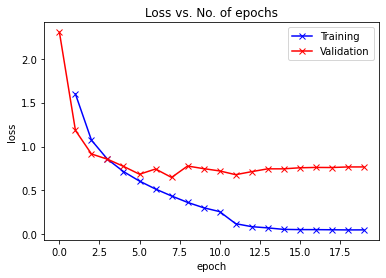

In [29]:
plot_losses(history)

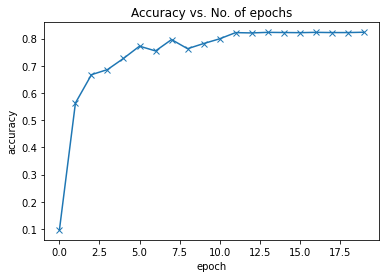

In [30]:
plot_accuracies(history)

In [31]:
evaluate(model, test_loader)

RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 15.90 GiB total capacity; 15.19 GiB already allocated; 31.88 MiB free; 15.21 GiB reserved in total by PyTorch)

In [32]:
!pip install jovian --upgrade --quiet
import jovian

<IPython.core.display.Javascript object>

In [33]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/anivorlis/03-cifar10-cnn


<IPython.core.display.Javascript object>

# Save model

In [121]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')

In [126]:
model2 = to_device(CIFAR10ModelCNN(cnn, fcl), device)
model2.load_state_dict(torch.load('cifar10-cnn.pth'))
evaluate(model2, test_loader)

RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 15.90 GiB total capacity; 15.23 GiB already allocated; 3.88 MiB free; 15.24 GiB reserved in total by PyTorch)